<a href="https://colab.research.google.com/github/ZahraArshia/sentiment_analysis/blob/main/SA_Digikala.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Digikala Sentiment Analysis

## handling data

In [44]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Dataset/digikala/data.csv', encoding='utf-8')

In [ ]:
df.head(10)

,Text,Score,Suggestion
0,این اولین تجربه من برای خرید ایفون هست امروز...,100,1
1,خرید این محصول رو توصیه میکنم,84,1
2,1 ساله این گوشی رو دارم هیچ نقطه ضعفی ازش ند...,60,1
3,سلام خدمت دوستان این گوشی از همه نظر عالی کیف...,96,1
4,سلام دوستانی که نگران شکستن صفحه نمایش هستند ا...,92,1
5,من پکیج کاملش روخریدم ازهرنظرعالیه هیچ نقد...,60,1
6,اول از همه خوشحالم که بالاخره نسخه های 128 گیگ...,96,1
7,من دو ماهه خریدم واقعا راضیم دوربینشم عالیه ...,100,1
8,بنظر من گوشی خوب و مقرون به صرفه ای بود توی ای...,100,1
9,از خریدم راضی ام و گوشی بینظیریه منتهی یه ایر...,92,1


In [ ]:
df.describe()

,Score,Suggestion
count,3261.000000,3261.00000
mean,74.719411,1.41061
std,21.514015,0.72408
min,0.000000,1.00000
25%,60.000000,1.00000
50%,80.000000,1.00000
75%,92.000000,2.00000
max,100.000000,3.00000


In [ ]:
df.isna().sum()

Text          0
Score         0
Suggestion    0
dtype: int64

<Axes: >

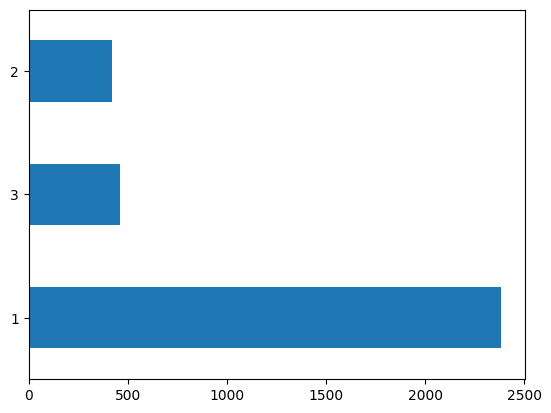

In [ ]:
df['Suggestion'].value_counts().plot(kind='barh')

<Axes: >

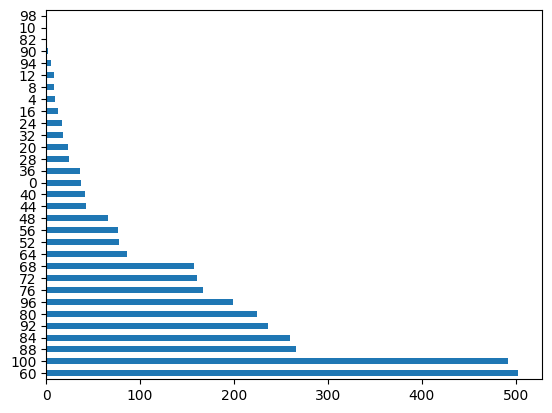

In [ ]:
df['Score'].value_counts().plot(kind='barh')

In [45]:
data = df[['Text', 'Score']]

In [46]:
data = data.dropna(subset=['Score'])
data = data.dropna(subset=['Text'])
data = data.drop_duplicates(subset=['Text'], keep='first')
data = data.reset_index(drop=True)

In [ ]:
!pip install hazm

In [ ]:
import hazm

In [ ]:
# calculate the length of comments based on their words
data['comment_len_by_words'] = data['Text'].apply(lambda t: len(hazm.word_tokenize(t)))

In [ ]:
min_max_len = data["comment_len_by_words"].min(), data["comment_len_by_words"].max()
print(f'Min: {min_max_len[0]} \tMax: {min_max_len[1]}')

In [ ]:
def data_gl_than(data, less_than=100.0, greater_than=0.0, col='comment_len_by_words'):
    data_length = data[col].values

    data_glt = sum([1 for length in data_length if greater_than < length <= less_than])

    data_glt_rate = (data_glt / len(data_length)) * 100

    print(f'Texts with word length of greater than {greater_than} and less than {less_than} includes {data_glt_rate:.2f}% of the whole!')

In [ ]:
data_gl_than(data, 256, 3)

Texts with word length of greater than 3 and less than 256 includes 95.47% of the whole!


In [ ]:
minlim, maxlim = 3, 256

In [ ]:
# remove comments with the length of fewer than three words
data['comment_len_by_words'] = data['comment_len_by_words'].apply(lambda len_t: len_t if minlim < len_t <= maxlim else None)
data = data.dropna(subset=['comment_len_by_words'])
data = data.reset_index(drop=True)

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=data['comment_len_by_words']
))

fig.update_layout(
    title_text='Distribution of word counts within comments',
    xaxis_title_text='Word Count',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

In [ ]:
unique_rates = list(sorted(data['Score'].unique()))
print(f'We have #{len(unique_rates)}: {unique_rates}')

We have #31: [0, 4, 8, 10, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 82, 84, 88, 90, 92, 94, 96, 98, 100]


In [ ]:
fig = go.Figure()

groupby_rate = data.groupby('Score')['Score'].count()

fig.add_trace(go.Bar(
    x=list(sorted(groupby_rate.index)),
    y=groupby_rate.tolist(),
    text=groupby_rate.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of rate within comments',
    xaxis_title_text='Score',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

In [47]:
def rate_to_label(rate):
    if rate <= 25:
        return 'bad'
    if 25 < rate <= 50:
        return 'not good'
    if 50 < rate <= 75:
        return 'good'
    else:
        return 'perfect'


data['label'] = data['Score'].apply(lambda t: rate_to_label(t))
labels = list(sorted(data['label'].unique()))
data.head()

,Text,Score,label
0,این اولین تجربه من برای خرید ایفون هست امروز...,100,perfect
1,خرید این محصول رو توصیه میکنم,84,perfect
2,1 ساله این گوشی رو دارم هیچ نقطه ضعفی ازش ند...,60,good
3,سلام خدمت دوستان این گوشی از همه نظر عالی کیف...,96,perfect
4,سلام دوستانی که نگران شکستن صفحه نمایش هستند ا...,92,perfect


## Data cleaning

In [ ]:
import re

def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext


def cleaning(text):
    text = text.strip()

    # regular cleaning
    text = clean(text,
        fix_unicode=True,
        to_ascii=False,
        lower=True,
        no_line_breaks=True,
        no_urls=True,
        no_emails=True,
        no_phone_numbers=True,
        no_numbers=False,
        no_digits=False,
        no_currency_symbols=True,
        no_punct=False,
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="0",
        replace_with_currency_symbol="",
    )

    # cleaning htmls
    text = cleanhtml(text)

    # normalizing
    normalizer = hazm.Normalizer()
    text = normalizer.normalize(text)

    # removing wierd patterns
    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        # u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)

    text = wierd_pattern.sub(r'', text)

    # removing extra spaces, hashtags
    text = re.sub("#", "", text)
    text = re.sub("\s+", " ", text)

    return text

In [ ]:
!pip install -qU clean-text[gpl]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 5.4 MB/s eta 0:00:00


In [ ]:
from cleantext import clean

# cleaning comments
data['cleaned_comment'] = data['Text'].apply(cleaning)


# calculate the length of comments based on their words
data['cleaned_comment_len_by_words'] = data['cleaned_comment'].apply(lambda t: len(hazm.word_tokenize(t)))

# remove comments with the length of fewer than three words
data['cleaned_comment_len_by_words'] = data['cleaned_comment_len_by_words'].apply(lambda len_t: len_t if minlim < len_t <= maxlim else len_t)
data = data.dropna(subset=['cleaned_comment_len_by_words'])
data = data.reset_index(drop=True)

data.head()

In [ ]:
# saving the dataframe
data.to_csv('/content/drive/MyDrive/Dataset/digikala/data_clean.csv')

In [41]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/Dataset/digikala/data_clean.csv', encoding='utf-8')

In [ ]:
data = data[['cleaned_comment', 'label']]
data.columns = ['Text', 'label']
data.head()

## Frequent Words

In [56]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [57]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize import RegexpTokenizer

In [58]:
def normalizer(txt):
    file = nltk.word_tokenize(txt)
    newfile=''
    for word in file:
        word = word.replace(" ", "").replace("\u200c", "").replace(".", ". ").upper().replace("\ufeff\n","").lower().replace(
            "،", "، ").upper().replace('ة' , 'ه').replace('ي', 'ی').replace("؛" , '؛ ').upper().replace("؛" , ' ؛').lower().replace("." , ' .').lower().replace(
            "،", " ،").lower().replace('\xa0','').replace('ک' , 'ك').replace('پ' , 'ب').replace('گ' ,'ك' )
        newfile = newfile + ' ' + word

    return newfile

In [59]:
def delete_Stopword(txt):
    file = nltk.word_tokenize(txt)
    newFile=''
    stopWord=[]
    fin=open('/content/drive/MyDrive/stopword.txt',encoding='utf8')

    for word in fin.readlines():
        stopWord.append(word.replace('\n', '').lower().replace('\ufeff', '').lower().replace('\ufeff', '').upper().replace('ك' , 'ک').replace(" " ,""))



    for word in file:
        word=word.replace(' ', '')
        if word in stopWord:
            continue
        else:
            newFile = newFile + ' ' + word


    return newFile

In [60]:
df2 = pd.read_csv('/content/drive/MyDrive/Dataset/digikala/data.csv', encoding='utf-8')

In [61]:
one_string = ''.join(df2['Text'].tolist())

In [65]:
doc = word_tokenize(delete_Stopword(one_string))

In [67]:
freq = {}
for word in doc:
  if word not in freq.keys():
    freq[word] = 1
  else:
    freq[word] += 1

In [68]:
max(freq.values())

1203

In [69]:
freq

{'اولین': 74,
 'تجربه': 57,
 'خرید': 467,
 'ایفون': 3,
 'دستم': 161,
 'رسیده': 32,
 'اسم': 16,
 'طلایی': 6,
 'دراصل': 1,
 'رزگلده': 1,
 'خوش': 76,
 'رنگ': 213,
 'محصول': 330,
 'توصیه': 86,
 'میکنم': 493,
 '1': 123,
 'ساله': 60,
 'گوشی': 248,
 'نقطه': 61,
 'ضعفی': 14,
 'ازش': 343,
 'ندیدم': 49,
 'سلام': 329,
 'خدمت': 40,
 'دوستان': 227,
 'نظر': 413,
 'عالی': 521,
 'کیفیت': 1137,
 'ساخت': 255,
 'سرعت': 169,
 'اجرا': 98,
 'صدا': 294,
 'تصویر': 144,
 'حافظه': 50,
 '5': 118,
 'گیگ': 32,
 'دسترس': 6,
 'قرار': 142,
 'میگیره': 41,
 'دوستانی': 53,
 'نگران': 25,
 'شکستن': 4,
 'صفحه': 319,
 'نمایش': 158,
 'بدونند': 1,
 'گوریلا': 1,
 'گلس': 4,
 'محافظت': 5,
 'میشه': 724,
 'سامسونگ': 88,
 'شرایط': 14,
 'دچار': 28,
 'ایراد': 42,
 'بشه': 193,
 '200': 11,
 'تومان': 12,
 'براتون': 60,
 'تعویض': 55,
 'میکنند': 12,
 'لحاظ': 107,
 'امکانات': 86,
 'عالیه': 590,
 'خودم': 118,
 'راضیم': 236,
 'پکیج': 4,
 'کاملش': 4,
 'روخریدم': 2,
 'ازهرنظرعالیه': 1,
 'نقدوایرادی': 1,
 'بهش': 92,
 'وارد': 39,
 'یه': 752,
 'ل

## Unbalanced Data !

In [48]:
import plotly.graph_objects as go

fig = go.Figure()

groupby_label = data.groupby('label')['label'].count()

fig.add_trace(go.Bar(
    x=list(sorted(groupby_label.index)),
    y=groupby_label.tolist(),
    text=groupby_label.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of label within comments [DATA]',
    xaxis_title_text='Label',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

## Train,Validation,Test split


In [10]:
from sklearn.model_selection import train_test_split

In [49]:
data['label_id'] = data['label'].apply(lambda t: labels.index(t))

train, test = train_test_split(data, test_size=0.1, random_state=1, stratify=data['label'])
train, valid = train_test_split(train, test_size=0.1, random_state=1, stratify=train['label'])

train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

x_train, y_train = train['Text'].values.tolist(), train['label_id'].values.tolist()
x_valid, y_valid = valid['Text'].values.tolist(), valid['label_id'].values.tolist()
x_test, y_test = test['Text'].values.tolist(), test['label_id'].values.tolist()

print(train.shape)
print(valid.shape)
print(test.shape)

(2446, 4)
(272, 4)
(303, 4)


In [50]:
print('Train sample:', x_train[0], y_train[0])

Train sample: درکل همه چیش خوبه  3


## PyTorch Configuration

In [13]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 37.1 MB/s eta 0:00:00


In [14]:
from transformers import BertConfig, BertTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch
import torch.nn as nn
import torch.nn.functional as F

In [16]:
# general config
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16

EPOCHS = 3
EEVERY_EPOCH = 1000
LEARNING_RATE = 2e-5
CLIP = 0.0

MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'
OUTPUT_PATH = './bert-fa-base-uncased-sentiment-digikala-v1'
OUTPUT_MODEL_PATH = f'{OUTPUT_PATH}/pytorch_model.bin'

print('OUTPUT_MODEL_PATH', OUTPUT_MODEL_PATH)
import os
os.makedirs(OUTPUT_PATH, exist_ok=True)

OUTPUT_MODEL_PATH ./bert-fa-base-uncased-sentiment-digikala-v1/pytorch_model.bin


In [51]:
# create a key finder based on label 2 id and id to label

label2id = {label: i for i, label in enumerate(labels)}
id2label = {v: k for k, v in label2id.items()}

print(f'label2id: {label2id}')
print(f'id2label: {id2label}')

label2id: {'bad': 0, 'good': 1, 'not good': 2, 'perfect': 3}
id2label: {0: 'bad', 1: 'good', 2: 'not good', 3: 'perfect'}


In [52]:
# setup the tokenizer and configuration

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
config = BertConfig.from_pretrained(
    MODEL_NAME_OR_PATH, **{
        'label2id': label2id,
        'id2label': id2label,
    })

print(config.to_json_string())

{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "bad",
    "1": "good",
    "2": "not good",
    "3": "perfect"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "bad": 0,
    "good": 1,
    "not good": 2,
    "perfect": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.32.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 100000
}



## Embeddings

In [ ]:
import numpy as np

In [54]:
idx = np.random.randint(0, len(train))
sample_comment = train.iloc[idx]['Text']
sample_label = train.iloc[idx]['label']

print(f'Sample: \n{sample_comment}\n{sample_label}')

Sample: 
من از این پرینتر هم برای کار سابلیمیشن هم برای چاپ عکس اتلیه استفاده میکنم دوتا مخزن مجزا برای هر دو نوع کارم گرفتم و واقعا کیفیتش خیلی بیشتر از اونیه که فکر میکردم خیلی عاااالیه شک نکنید  خطاهایی هم که میده رابطه مستقیمی با نابلدی استفاده کننده داره   
good


In [20]:
tokens = tokenizer.tokenize(sample_comment)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'  Comment: {sample_comment}')
print(f'   Tokens: {tokenizer.convert_tokens_to_string(tokens)}')
print(f'Token IDs: {token_ids}')

  Comment: قبل این رونیکس داشتم که چکشی نبود و زود خراب شد اما این دریل واقعا عالیه تو شگفت‌انگیز خریدم و باید بگم واقعا می‌ارزه
   Tokens: قبل این رونیکس داشتم که چکشی نبود و زود خراب شد اما این دریل واقعا عالیه تو شگفتانگیز خریدم و باید بگم واقعا میارزه
Token IDs: [3556, 2802, 28025, 3233, 8065, 2800, 47215, 3827, 1379, 5505, 8415, 2817, 2949, 2802, 47840, 5668, 19142, 2861, 12197, 38993, 1379, 3013, 18757, 5668, 24003, 3223]


In [21]:
encoding = tokenizer.encode_plus(
    sample_comment,
    max_length=32,
    truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=True,
    return_attention_mask=True,
    padding='max_length',
    return_tensors='pt',  # Return PyTorch tensors
)

print(f'Keys: {encoding.keys()}\n')
for k in encoding.keys():
    print(f'{k}:\n{encoding[k]}')

Keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

input_ids:
tensor([[    2,  3556,  2802, 28025,  3233,  8065,  2800, 47215,  3827,  1379,
          5505,  8415,  2817,  2949,  2802, 47840,  5668, 19142,  2861, 12197,
         38993,  1379,  3013, 18757,  5668, 24003,  3223,     4,     0,     0,
             0,     0]])
token_type_ids:
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])
attention_mask:
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 0, 0, 0, 0]])


## Input Data

In [22]:
class TaaghcheDataset(torch.utils.data.Dataset):
    """ Create a PyTorch dataset for digikala. """

    def __init__(self, tokenizer, comments, targets=None, label_list=None, max_len=128):
        self.comments = comments
        self.targets = targets
        self.has_target = isinstance(targets, list) or isinstance(targets, np.ndarray)

        self.tokenizer = tokenizer
        self.max_len = max_len


        self.label_map = {label: i for i, label in enumerate(label_list)} if isinstance(label_list, list) else {}

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, item):
        comment = str(self.comments[item])

        if self.has_target:
            target = self.label_map.get(str(self.targets[item]), str(self.targets[item]))

        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt')

        inputs = {
            'comment': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
        }

        if self.has_target:
            inputs['targets'] = torch.tensor(target, dtype=torch.long)

        return inputs


def create_data_loader(x, y, tokenizer, max_len, batch_size, label_list):
    dataset = TaaghcheDataset(
        comments=x,
        targets=y,
        tokenizer=tokenizer,
        max_len=max_len,
        label_list=label_list)

    return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [55]:
label_list = ['bad', 'not good', 'good', 'perfect']
train_data_loader = create_data_loader(train['Text'].to_numpy(), train['label'].to_numpy(), tokenizer, MAX_LEN, TRAIN_BATCH_SIZE, label_list)
valid_data_loader = create_data_loader(valid['Text'].to_numpy(), valid['label'].to_numpy(), tokenizer, MAX_LEN, VALID_BATCH_SIZE, label_list)
test_data_loader = create_data_loader(test['Text'].to_numpy(), None, tokenizer, MAX_LEN, TEST_BATCH_SIZE, label_list)

In [24]:
sample_data = next(iter(train_data_loader))

print(sample_data.keys())

print(sample_data['comment'])
print(sample_data['input_ids'].shape)
print(sample_data['input_ids'][0, :])
print(sample_data['attention_mask'].shape)
print(sample_data['attention_mask'][0, :])
print(sample_data['token_type_ids'].shape)
print(sample_data['token_type_ids'][0, :])
print(sample_data['targets'].shape)
print(sample_data['targets'][0])

dict_keys(['comment', 'input_ids', 'attention_mask', 'token_type_ids', 'targets'])
['ساخت مجارستان کیفیت ساخت و کارایی عالی تنها نکته منفی نداشتن باتری اضافه ست', 'به نظر میرسه دستگاه خوبی باشه قبل از این دستگاه بخار پز فلر داشتم و استفاده زیادی داشتیم ازش مخصوصا برای پخت برنج و بخاطر ظرفیت بیشتر اینو خریدم در نگاه اول با کیفیت به نظر میرسه مخصوصا محصولات پارس خزر که تونسته در تمامی این سال\u200cها اصالت و کیفیت خودش رو حفظ کنه ایراد خاصی نداره و میشه بهش اعتماد کرد', 'بوش یعنی کیفیت ایمنی تو شگفت\u200cانگیز خریدم و ازش راضیم واسه کارای سبک و خانگی عالیه به شرط اینکه از منه بوش استفاده بشه', 'واقعا فوق\u200cالعاده است کار باهاش راحته در خریدش شک نکنید با اتو\u200cهای معمولی قابل\u200cمقایسه نیست', 'این لپتاپ عالیه کافیه روش یه اس اس دی بندارین تا بشه تمام دنیاتون', 'شیک و باکیفیت می\u200cباشد', 'بازی injustice ۲ بسیار بهتر از نسخه قبلی هست و حتما پیشنهاد می\u200cکنم امتحان کنید با داستان بسیار محیج خود کنسول هم خیلی خوب کار میکنه ولی اگر نزدیک ۱ ساعت بازی کنید کمی داغ میکنه تنها مشکل ا

In [25]:
sample_test = next(iter(test_data_loader))
print(sample_test.keys())

dict_keys(['comment', 'input_ids', 'attention_mask', 'token_type_ids'])


## Model

In [26]:
class SentimentModel(nn.Module):

    def __init__(self, config):
        super(SentimentModel, self).__init__()

        self.bert = BertModel.from_pretrained(MODEL_NAME_OR_PATH)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, input_ids, attention_mask, token_type_ids):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=False)

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

In [27]:
pt_model = SentimentModel(config=config)
pt_model = pt_model.to(device)

print('pt_model', type(pt_model))

pt_model <class '__main__.SentimentModel'>


## Training

In [28]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

In [29]:
def simple_accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

def acc_and_f1(y_true, y_pred, average='weighted'):
    acc = simple_accuracy(y_true, y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average=average)
    return {
        "acc": acc,
        "f1": f1,
    }

def y_loss(y_true, y_pred, losses):
    y_true = torch.stack(y_true).cpu().detach().numpy()
    y_pred = torch.stack(y_pred).cpu().detach().numpy()
    y = [y_true, y_pred]
    loss = np.mean(losses)

    return y, loss


def eval_op(model, data_loader, loss_fn):
    model.eval()

    losses = []
    y_pred = []
    y_true = []

    with torch.no_grad():
        for dl in tqdm(data_loader, total=len(data_loader), desc="Evaluation... "):

            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']
            targets = dl['targets']

            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)

            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)

            # calculate the batch loss
            loss = loss_fn(outputs, targets)

            # accumulate all the losses
            losses.append(loss.item())

            y_pred.extend(preds)
            y_true.extend(targets)

    eval_y, eval_loss = y_loss(y_true, y_pred, losses)
    return eval_y, eval_loss


def train_op(model,
             data_loader,
             loss_fn,
             optimizer,
             scheduler,
             step=0,
             print_every_step=100,
             eval=False,
             eval_cb=None,
             eval_loss_min=np.Inf,
             eval_data_loader=None,
             clip=0.0):

    model.train()

    losses = []
    y_pred = []
    y_true = []

    for dl in tqdm(data_loader, total=len(data_loader), desc="Training... "):
        step += 1

        input_ids = dl['input_ids']
        attention_mask = dl['attention_mask']
        token_type_ids = dl['token_type_ids']
        targets = dl['targets']

        # clear the gradients of all optimized variables
        optimizer.zero_grad()

        # compute predicted outputs by passing inputs to the model
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids)

        # convert output probabilities to predicted class
        _, preds = torch.max(outputs, dim=1)

        # calculate the batch loss
        loss = loss_fn(outputs, targets)

        # accumulate all the losses
        losses.append(loss.item())

        # compute gradient of the loss with respect to model parameters
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        if clip > 0.0:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)

        # perform optimization step
        optimizer.step()

        # perform scheduler step
        scheduler.step()

        y_pred.extend(preds)
        y_true.extend(targets)

        if eval:
            train_y, train_loss = y_loss(y_true, y_pred, losses)
            train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')

            if step % print_every_step == 0:
                eval_y, eval_loss = eval_op(model, eval_data_loader, loss_fn)
                eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')

                if hasattr(eval_cb, '__call__'):
                    eval_loss_min = eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min)

    train_y, train_loss = y_loss(y_true, y_pred, losses)

    return train_y, train_loss, step, eval_loss_min

In [30]:
import collections
from tqdm.notebook import tqdm

In [31]:
optimizer = AdamW(pt_model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss()

step = 0
eval_loss_min = np.Inf
history = collections.defaultdict(list)


def eval_callback(epoch, epochs, output_path):
    def eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min):
        statement = ''
        statement += 'Epoch: {}/{}...'.format(epoch, epochs)
        statement += 'Step: {}...'.format(step)

        statement += 'Train Loss: {:.6f}...'.format(train_loss)
        statement += 'Train Acc: {:.3f}...'.format(train_score['acc'])

        statement += 'Valid Loss: {:.6f}...'.format(eval_loss)
        statement += 'Valid Acc: {:.3f}...'.format(eval_score['acc'])

        print(statement)

        if eval_loss <= eval_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                eval_loss_min,
                eval_loss))

            torch.save(model.state_dict(), output_path)
            eval_loss_min = eval_loss

        return eval_loss_min


    return eval_cb


for epoch in tqdm(range(1, EPOCHS + 1), desc="Epochs... "):
    train_y, train_loss, step, eval_loss_min = train_op(
        model=pt_model,
        data_loader=train_data_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        scheduler=scheduler,
        step=step,
        print_every_step=EEVERY_EPOCH,
        eval=True,
        eval_cb=eval_callback(epoch, EPOCHS, OUTPUT_MODEL_PATH),
        eval_loss_min=eval_loss_min,
        eval_data_loader=valid_data_loader,
        clip=CLIP)

    train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')

    eval_y, eval_loss = eval_op(
        model=pt_model,
        data_loader=valid_data_loader,
        loss_fn=loss_fn)

    eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')

    history['train_acc'].append(train_score['acc'])
    history['train_loss'].append(train_loss)
    history['val_acc'].append(eval_score['acc'])
    history['val_loss'].append(eval_loss)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



Epochs... :   0%|          | 0/3 [00:00<?, ?it/s]

Training... :   0%|          | 0/146 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/17 [00:00<?, ?it/s]

Training... :   0%|          | 0/146 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/17 [00:00<?, ?it/s]

Training... :   0%|          | 0/146 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/17 [00:00<?, ?it/s]

In [32]:
!ls {OUTPUT_PATH}

## Prediction/Evaluation

In [33]:
def predict(model, comments, tokenizer, max_len=128, batch_size=32):
    data_loader = create_data_loader(comments, None, tokenizer, max_len, batch_size, None)

    predictions = []
    prediction_probs = []


    model.eval()
    with torch.no_grad():
        for dl in tqdm(data_loader, position=0):
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']

            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)

            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds)
            prediction_probs.extend(F.softmax(outputs, dim=1))

    predictions = torch.stack(predictions).cpu().detach().numpy()
    prediction_probs = torch.stack(prediction_probs).cpu().detach().numpy()

    return predictions, prediction_probs

In [35]:
test_comments = test['Text'].to_numpy()
preds, probs = predict(pt_model, test_comments, tokenizer, max_len=128)

print(preds.shape, probs.shape)

  0%|          | 0/10 [00:00<?, ?it/s]

(289,) (289, 2)


In [ ]:
y_test, y_pred = [label_list.index(label) for label in test['label'].values], preds

print(f'F1: {f1_score(y_test, y_pred, average="weighted")}')
print()
print(classification_report(y_test, y_pred, target_names=label_list))